This tutorial will demonstrate how to pre-process single-cell raw UMI counts to generate expression matrices that can be used as input to cell-cell communication tools. We recommend the [quality control](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) chapter in the Single-cell Best Practices book as a starting point for a detailed overview of QC and single-cell RNAseq analysis pipelines in general. 

Here we will focus on:
1. Normalization
2. Inter-operability between R and python. 

We demonstrate a typical workflow using the popular single-cell analysis software [scanpy](https://scanpy.readthedocs.io/en/stable/) to generate an AnnData object which can be used downstream. We will use a [BALF COVID dataset](https://doi.org/10.1038/s41591-020-0901-9), which contains 12 samples associated with "Healthy Control", "Moderate", or "Severe" COVID contexts.

Details and caveats regarding [batch correction](https://www.nature.com/articles/s41592-018-0254-1), which removes technical variation while preserving biological variation between samples, can be viewed in the additional examples tutorial entitled "S1_Batch_Correction".

## Preparare the object for cell-cell communication analysis

Here, I just do the basic processing as it makes sense to me to be seperate from the scoring function chapter

In [1]:
import os

import scanpy as sc
import pandas as pd
import numpy as np

import cell2cell as c2c

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = '../../data/' # '/data/hratch/ccc_protocols/interim/' # #<-uncomment in final
c2c.io.directories.create_directory(data_path)

../../data/ already exists.


#### Loading

The 12 samples can be downloaded as .h5 files from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145926). You can also download the cell metadata from [here](https://raw.githubusercontent.com/zhangzlab/covid_balf/master/all.cell.annotation.meta.txt)

Alternatively, cell2cell has a helper function to load the data as an AnnData object:

In [4]:
adata = c2c.datasets.balf_covid()

In [5]:
adata

AnnData object with n_obs × n_vars = 63103 × 33538
    obs: 'sample', 'sample_new', 'group', 'disease', 'hasnCoV', 'cluster', 'celltype', 'condition'

In [6]:
adata.obs.head()

,sample,sample_new,group,disease,hasnCoV,cluster,celltype,condition
AAACCCACAGCTACAT_3,C100,HC3,HC,N,N,27.0,B,Control
AAACCCATCCACGGGT_3,C100,HC3,HC,N,N,23.0,Macrophages,Control
AAACCCATCCCATTCG_3,C100,HC3,HC,N,N,6.0,T,Control
AAACGAACAAACAGGC_3,C100,HC3,HC,N,N,10.0,Macrophages,Control
AAACGAAGTCGCACAC_3,C100,HC3,HC,N,N,10.0,Macrophages,Control


In [7]:
adata.obs.condition.unique()

['Control', 'Moderate COVID-19', 'Severe COVID-19']
Categories (3, object): ['Control', 'Moderate COVID-19', 'Severe COVID-19']

#### Basic Filtering

Exclude cells that visually do not fall within the normal range of standard QC metrics (see [chapter](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html)) -- fraction of genes in a cell that are mitochondrial, number of unique genes, and total number of genes measured. 

**Note, had to change n_genes_by_counts to n_genes to match the seurat filtering**

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

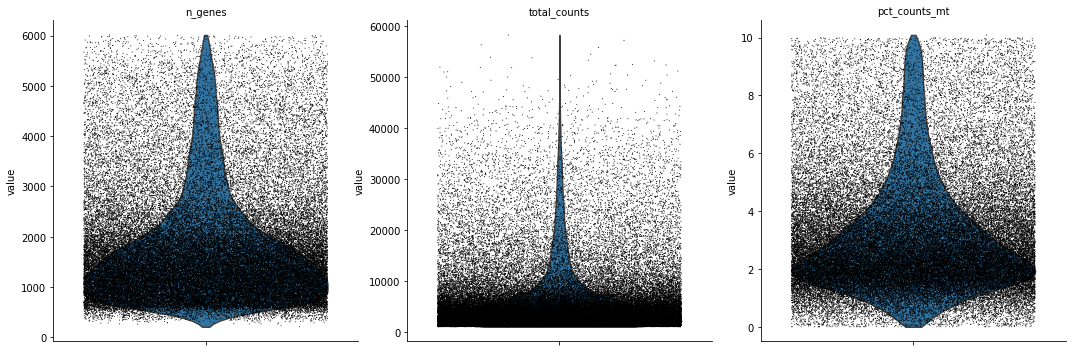

In [10]:
sc.pl.violin(adata, ['n_genes', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

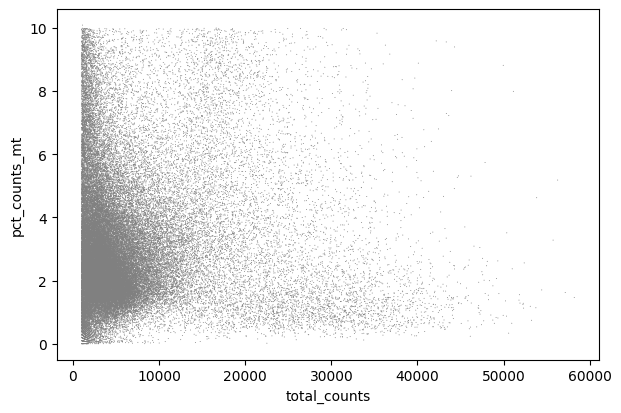

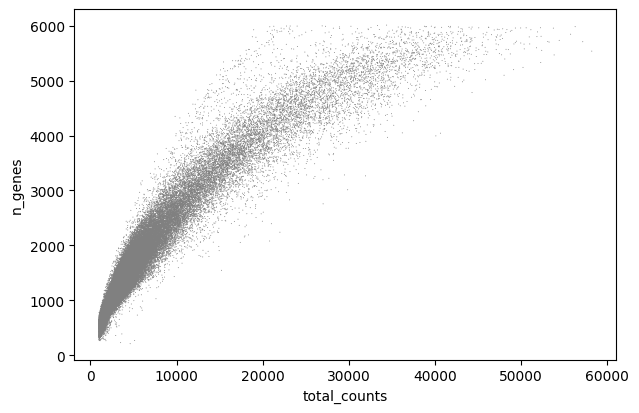

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes')

In [12]:
adata = adata[adata.obs.n_genes < 5500, :] 
adata = adata[adata.obs.pct_counts_mt < 15, :]

In [13]:
adata

View of AnnData object with n_obs × n_vars = 62551 × 24798
    obs: 'sample', 'sample_new', 'group', 'disease', 'hasnCoV', 'cluster', 'celltype', 'condition', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

#### Normalize

For single-cell inference across sample and across cell types, most CCC tools require the library sizes to be comparable. We can use the scanpy function `sc.pp.normalize_total` to normalize the library sizes. This function divides each cell by the total counts per cell and multiplies by the median of the total counts per cell. Furthermore, we log1p-transform the data to make it more Gaussian-like, as this is a common assumption for the analyses downstream. Finally, such a normalization maintains non-negative counts, which is important for tensor decomposition.

In [14]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
# Daniel: This would make any local PC explode, so better to skip it :)
# ordered_genes = sorted(adata.var.index)
# adata.to_df().T.loc[ordered_genes,:].head()

#### Dimensionality Reduction

While dimensionality reduction is not used directly in these tutorials, a number of these steps are necessary to obtain cell group labels when processing your own data. Steps such as filtering for highly variable genes (HVGs) and scaling the data improve dimensionality reudction and clustering results. However, for CCC, we recommend using the entire gene expression matrix unscaled (either raw or library- and log-normalized). Scaling introduces negative counts, which poses challenges for CCC inference or tensor decompsoition. Filtering for HVGs reduces the list of potential ligand-receptor pairs that can be tested for interactions.

This tutorial diverges with its companion tutorial in R here due to minor algorithmic differences, but since the inputs will be the full expression matrices above, these discrepancies will not affect downstream tutorials. 

In [15]:
sc.pp.highly_variable_genes(adata, flavor = 'seurat', n_top_genes = 2000, batch_key="sample") # Daniel: I added batch_key here, SingleCellExperiment also supports it, not sure about Seurat

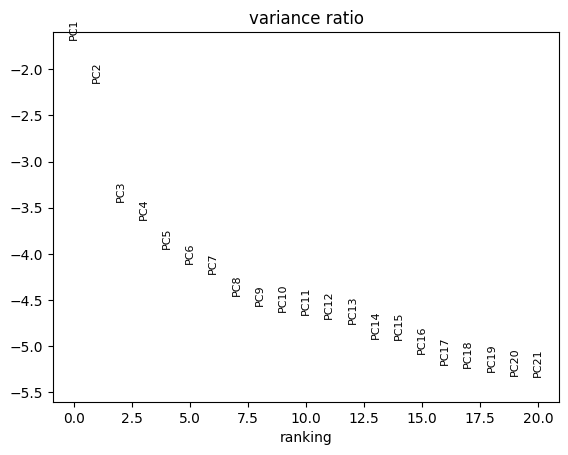

In [16]:
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable = True)

sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 20) # visualize PCA variance explained

Of course, would be better to replot the UMAP with integrated data :) - I just needed the normalized counts for the second chapter :) ##TODO

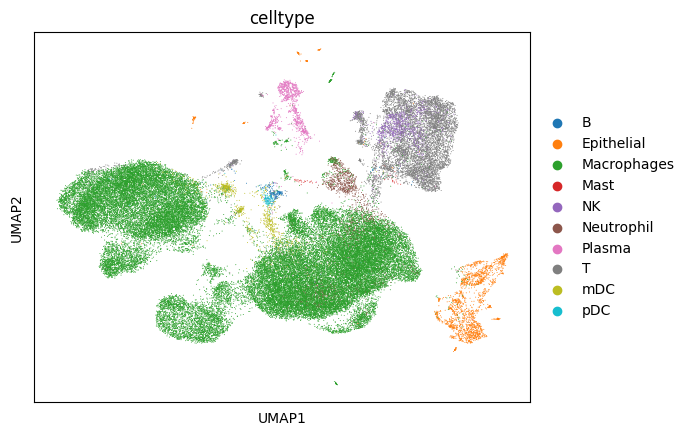

In [17]:
n_pcs=20
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=n_pcs)
sc.tl.umap(adata)

# plot pre-annotated cell types
sc.pl.umap(adata, color=['celltype']) ###

Save the data for downsteam analysis

In [18]:
# save
adata.write_h5ad(os.path.join(data_path, 'processed.h5ad'), compression='gzip')

# Interoperability

## to R

For use in R, the .h5ad file saved in the above cell can be loaded in R as a SeuratObject using SeuratDisk. See the companion R tutorial for loading these saved files.

## from R

Here, we can load the data that was generated in the companion R script using Seurat and saved as h5ad files:

In [ ]:
file_name = os.path.join(data_path, 'processed_fromR_toPython.h5ad')
adata_fromR = sc.read_h5ad(file_name)